In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data = pd.read_csv('C:/Users/Admin/Desktop/Python/Kaggle/Projects/Titanic/train.csv')

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Describe the data 

In [4]:
train_data.describe().transpose() #transpose() re-position the row and column

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


### See num of Nan value 

In [5]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Check correlation

In [6]:
train_data.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


transform the above table into a heatmap for visualization:

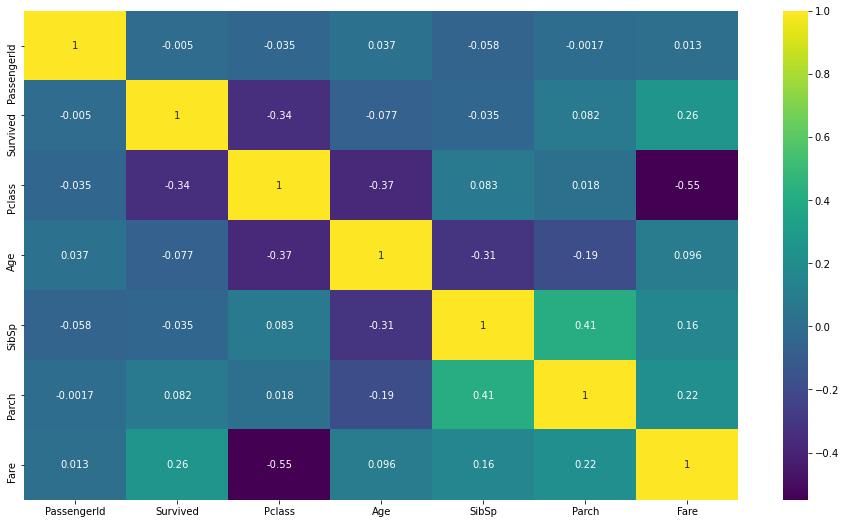

In [7]:
plt.figure(figsize=(16,9))
sns.heatmap(train_data.corr(), annot=True, cmap='viridis') #annot=True to add number, cmap is color map.
plt.show()

Looking at the heatmap above, we can see that only the corr between PassengerId and Survived is insignificant.Therefore, we will exclude this column when building our model.

### Survived and Pclass 

In [8]:
train_data.groupby('Pclass').mean().Survived

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

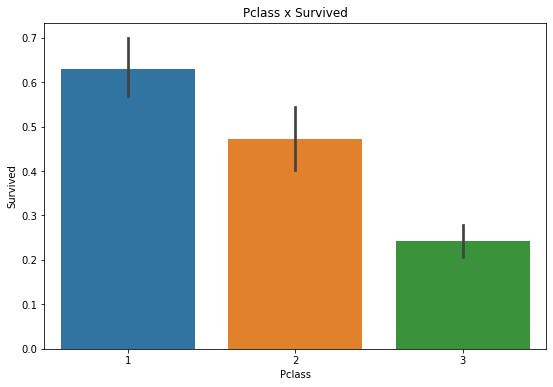

In [9]:
plt.figure(figsize=(9,6))
sns.barplot(x='Pclass', y='Survived', data=train_data)
plt.title('Pclass x Survived')
plt.show()

Logically and evidently, the Pclass and Fare data also has high corr: the higher the fare, the higher the class. And the higher the class, the higher the survival % (it seems). Howver, we can't conclude that **the higher the fare, the higher the survival %** yet, since the fare inside each Pclass is also different. We can check this assumption:

In [10]:
train_data.groupby(['Pclass','Survived']).mean().Fare

Pclass  Survived
1       0           64.684008
        1           95.608029
2       0           19.412328
        1           22.055700
3       0           13.669364
        1           13.694887
Name: Fare, dtype: float64

We can visualize the table above by using 3 different barplot for each Pclass:

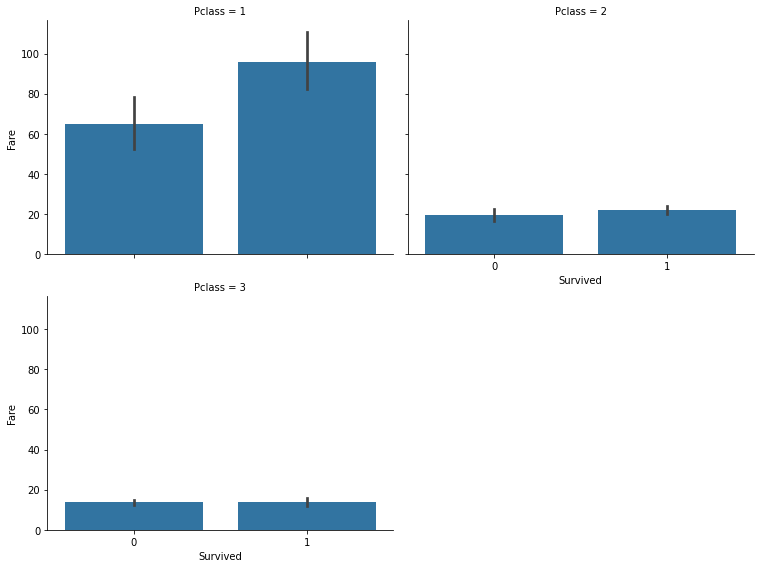

In [11]:
sns.FacetGrid(train_data, col='Pclass', height=4, aspect=4/3, col_wrap=2).map(sns.barplot, 'Survived', 'Fare',  order=[0,1])
plt.show()

The charts above shows that even within a Pclass, higher fare also leads to higher survival %. 

**Conclusuon:** both Pclass and Fare need to be included in our model.

### Survived and Sex 

In [12]:
train_data.loc[(train_data.Sex=='male'),'Sex']=1
train_data.loc[(train_data.Sex=='female'), 'Sex']=0
train_data.groupby('Sex').mean().Survived

Sex
0    0.742038
1    0.188908
Name: Survived, dtype: float64

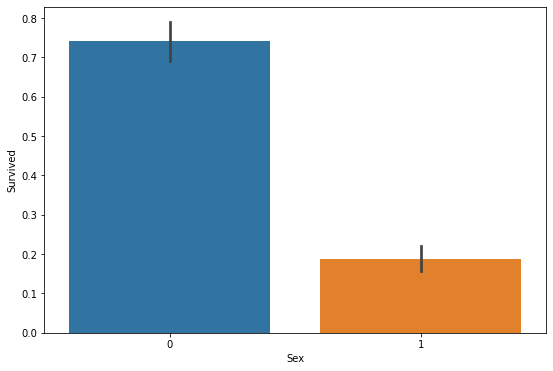

In [13]:
plt.figure(figsize=(9,6))
sns.barplot(x='Sex', y='Survived', data=train_data)
plt.show()

As we can see, female has a substantially higher % of survival. Therefore, Sex will be an important factor.

### Survived and Age

Since Age has some missing values, first we have to fill in these missing values first.
* **Method 1:** replace NaN with mean age.
* **Method 2:** replace Nan with mean age from the Pclass, since Pclass and Age seems to have a high corr. Or alternatively, we can replace Pclass with SibSp.

#### Method 1: replace with mean

In [14]:
train_data.loc[(train_data.Age.isnull()),'Age']= train_data.Age.mean()

In [15]:
#Divide Age into Age groups
Survived_age = train_data.groupby(['Survived', 'Age']).Age.agg([len])
Survived_age_0=Survived_age.loc[0,:]
Survived_age_0=Survived_age_0.reset_index()
Survived_age_0['Age_group']=""
Survived_age_0.loc[:,'Age_group']=0
Survived_age_0.loc[(Survived_age_0.Age>=17),'Age_group']=1
Survived_age_0.loc[(Survived_age_0.Age>=33),'Age_group']=2
Survived_age_0.loc[(Survived_age_0.Age>=49),'Age_group']=3
Survived_age_0.loc[(Survived_age_0.Age>=65),'Age_group']=4
Survived_age_1=Survived_age.loc[1,:]
Survived_age_1=Survived_age_1.reset_index()
Survived_age_1['Age_group']=""
Survived_age_1.loc[:,'Age_group']=0
Survived_age_1.loc[(Survived_age_1.Age>=17),'Age_group']=1
Survived_age_1.loc[(Survived_age_1.Age>=33),'Age_group']=2
Survived_age_1.loc[(Survived_age_1.Age>=49),'Age_group']=3
Survived_age_1.loc[(Survived_age_1.Age>=65),'Age_group']=4

In [16]:
#Merge into one DataFrame
a = Survived_age_0.groupby('Age_group').count().len
b = Survived_age_1.groupby('Age_group').count().len
Age_group = pd.concat([a,b], axis=1)
Age_group.columns = ['Survived_0', 'Survived_1']
Age_group['%']= Age_group.Survived_1/(Age_group.Survived_0+Age_group.Survived_1)
Age_group = Age_group.reset_index()

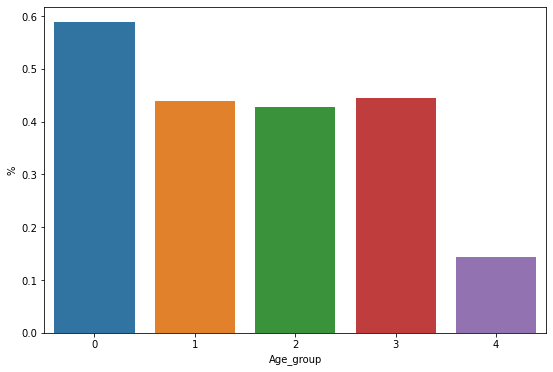

In [17]:
plt.figure(figsize=(9,6))
sns.barplot(x ='Age_group',y='%', data=Age_group)
plt.show()

From the chart above, we can see that the general trend is that higher age leads to lower survival %.

### Survived and SibSp 

In [18]:
SibSp = train_data.groupby(['SibSp','Survived']).SibSp.agg([len])
SibSp = SibSp / SibSp.groupby(level=0).sum() #convert to %
SibSp = SibSp.reset_index()
data = SibSp.loc[(SibSp.Survived==1)]

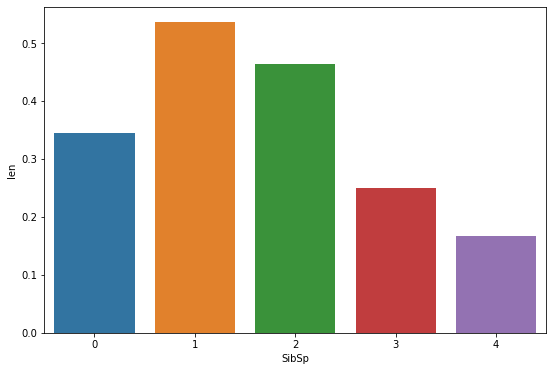

In [19]:
plt.figure(figsize=(9,6))
sns.barplot(x = 'SibSp', y='len', data=data)
plt.show()

### Survived and Parch

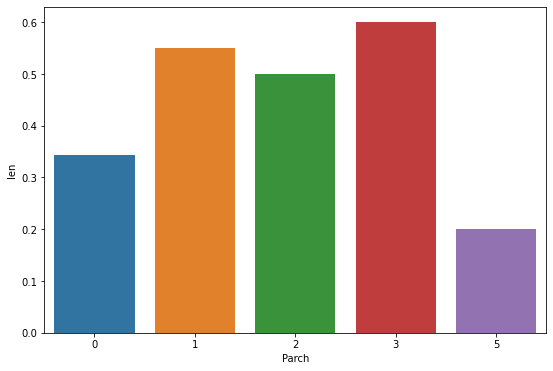

In [20]:
Parch = train_data.groupby(['Parch', 'Survived']).Parch.agg([len])
Parch = Parch / Parch.groupby(level=0).sum()
plt.figure(figsize=(9,6))
sns.barplot(x='Parch', y='len', data=Parch.reset_index().loc[(Parch.reset_index().Survived==1)])
plt.show()

### Embarked and Survived 

In [21]:
Embarked = train_data.groupby(['Embarked','Survived']).Survived.agg([len])
Embarked = Embarked / Embarked.groupby(level=0).sum()
Embarked

len
Embarked Survived          
C        0         0.446429
         1         0.553571
Q        0         0.610390
         1         0.389610
S        0         0.663043
         1         0.336957

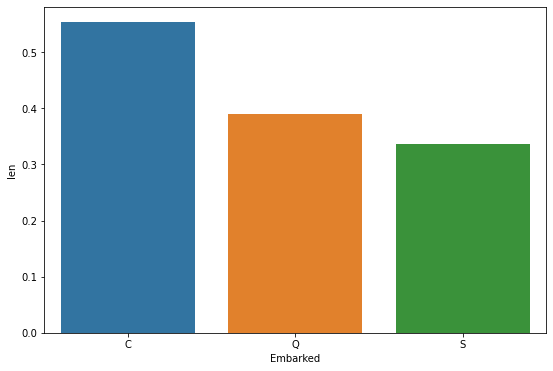

In [22]:
plt.figure(figsize=(9,6))
sns.barplot(x='Embarked', y='len', data=Embarked.reset_index().loc[(Embarked.reset_index().Survived==1)])
plt.show()

Clearly Embarked does have a high impact on the survival %. Therefore we have to include this column in our model. Which means, we have to fill in the missing values of Embarked.

In [23]:
train_data.loc[(train_data.Embarked.isna())]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",0,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",0,62.0,0,0,113572,80.0,B28,NaN


In [24]:
train_data.groupby('Embarked').Fare.mean()

Embarked
C    59.954144
Q    13.276030
S    27.079812
Name: Fare, dtype: float64

In [25]:
train_data.groupby(['Embarked','Pclass']).Pclass.size()

Embarked  Pclass
C         1          85
          2          17
          3          66
Q         1           2
          2           3
          3          72
S         1         127
          2         164
          3         353
Name: Pclass, dtype: int64

Looking at the relationship between Embarked and Pclass/Fare, we can assume that there's a high possibility that both passenger's Embarked location is C.

In [26]:
train_data.loc[(train_data.Embarked.isna()),'Embarked']='C'

We also have to encode the Embarked into numerical data to run our model.

In [27]:
train_data.loc[(train_data.Embarked=='C'),'Embarked']=1.66
train_data.loc[(train_data.Embarked=='Q'),'Embarked']=1.15
train_data.loc[(train_data.Embarked=='S'),'Embarked']=1

In [28]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,1.66
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,1


## Create the model 

In [29]:
from sklearn.ensemble import RandomForestRegressor

In [30]:
model = RandomForestRegressor(random_state=8)

In [31]:
train_y = train_data.Survived
train_X = train_data[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]

In [32]:
model.fit(train_X, train_y)

RandomForestRegressor(random_state=8)

## Read test data 

In [33]:
test_data = pd.read_csv('C:/Users/Admin/Desktop/Python/Kaggle/Projects/Titanic/test.csv')
test_data.loc[(test_data.Sex=='male'),'Sex']=1
test_data.loc[(test_data.Sex=='female'), 'Sex']=0
test_data.loc[(test_data.Embarked=='C'),'Embarked']=1.66
test_data.loc[(test_data.Embarked=='Q'),'Embarked']=1.15
test_data.loc[(test_data.Embarked=='S'),'Embarked']=1

In [34]:
test_data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

First we have to fill in these missing values.

### Fill in Age 

We will still follow method 1:

In [35]:
test_data.loc[(test_data.Age.isnull()),'Age']= test_data.Age.mean()

### Fill in Fare 

Since Fare and Pclass has high correlation, we will look at the Pclass to make an assumption:

In [36]:
test_data.loc[(test_data.Fare.isna())]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",1,60.5,0,0,3701,NaN,NaN,1


In [37]:
train_data.groupby('Pclass').Fare.mean()

Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64

In [38]:
test_data.loc[(test_data.Fare.isna()),'Fare']=13.676

## Run the model

In [39]:
test_X=test_data[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]

In [40]:
test_data['Survived'] = model.predict(test_X)

In [41]:
test_data.loc[(test_data.Survived<0.5),'Survived']=0
test_data.loc[(test_data.Survived>=0.5),'Survived']=1
for col in ['Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']:
    del test_data[col]
test_data = test_data.set_index('PassengerId')

In [42]:
test_data

,Survived
PassengerId,
892,0.0
893,0.0
894,0.0
895,1.0
896,1.0
...,...
1305,0.0
1306,1.0
1307,0.0


In [43]:
test_data.loc[:,'Survived']=test_data.Survived.astype(int)

In [44]:
test_data

,Survived
PassengerId,
892,0
893,0
894,0
895,1
896,1
...,...
1305,0
1306,1
1307,0


In [45]:
test_data.to_csv('C:/Users/Admin/Desktop/Python/Kaggle/Projects/Titanic/result_3.csv')

## Method 2 of replacing Age 

In [46]:
train_data.groupby('Pclass').Age.mean()

Pclass
1    37.048118
2    29.866958
3    26.403259
Name: Age, dtype: float64

In [47]:
test_data = pd.read_csv('C:/Users/Admin/Desktop/Python/Kaggle/Projects/Titanic/test.csv')

In [48]:
test_data.Age.isna().sum()

86

In [51]:
test_data.loc[(test_data.Age.isna())&(test_data.Pclass==1),'Age']=37.048
test_data.loc[(test_data.Age.isna())&(test_data.Pclass==2),'Age']=29.867
test_data.loc[(test_data.Age.isna())&(test_data.Pclass==3),'Age']=26.403

In [52]:
test_data.loc[(test_data.Sex=='male'),'Sex']=1
test_data.loc[(test_data.Sex=='female'), 'Sex']=0
test_data.loc[(test_data.Embarked=='C'),'Embarked']=1.66
test_data.loc[(test_data.Embarked=='Q'),'Embarked']=1.15
test_data.loc[(test_data.Embarked=='S'),'Embarked']=1

In [53]:
test_data.loc[(test_data.Fare.isna()),'Fare']=13.676

In [55]:
test_X=test_data[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]

In [56]:
test_data['Survived'] = model.predict(test_X)

In [57]:
test_data.loc[(test_data.Survived<0.5),'Survived']=0
test_data.loc[(test_data.Survived>=0.5),'Survived']=1
for col in ['Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']:
    del test_data[col]
test_data = test_data.set_index('PassengerId')

In [58]:
test_data.loc[:,'Survived']=test_data.Survived.astype(int)

In [59]:
test_data.to_csv('C:/Users/Admin/Desktop/Python/Kaggle/Projects/Titanic/result_4.csv')